# Feature Engineering for Telco Customer Churn

This notebook demonstrates and documents feature engineering steps for the Telco Customer Churn dataset, including encoding, transformations, and new feature creation.

In [1]:
# Fix sys.path for module import
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import Required Libraries
import pandas as pd
import numpy as np
from src.preprocess.dataloader import load_telco_data



In [3]:
# Load Data
train_df, test_df, val_df = load_telco_data(path="../data/data.csv")
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape if val_df is not None else 'N/A'}")
print(f"Test shape: {test_df.shape}")

Train shape: (5070, 21)
Validation shape: (564, 21)
Test shape: (1409, 21)


## Feature Engineering Steps

- Drop or encode the 'customerID' column
- Convert 'TotalCharges' to numeric and handle errors
- Encode categorical variables (label encoding for binary, one-hot for multi-class)
- Create new features (e.g., tenure groups)
- Document all changes and rationale

In [4]:
# Drop or encode 'customerID' and convert 'TotalCharges' to numeric
def preprocess_basic(df):
    df = df.copy()
    if 'customerID' in df.columns:
        df = df.drop('customerID', axis=1)
    if 'TotalCharges' in df.columns:
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    return df

train_df = preprocess_basic(train_df)
val_df = preprocess_basic(val_df) if val_df is not None else None
test_df = preprocess_basic(test_df)

print('customerID dropped and TotalCharges converted to numeric.')

customerID dropped and TotalCharges converted to numeric.


In [5]:
# Encode categorical variables
def encode_categoricals(df):
    df = df.copy()
    for col in df.select_dtypes(include=['object', 'category']).columns:
        if df[col].nunique() == 2:
            # Binary: label encoding
            df[col] = df[col].astype('category').cat.codes
        else:
            # Multi-class: one-hot encoding
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df.drop(col, axis=1), dummies], axis=1)
    return df

train_df = encode_categoricals(train_df)
val_df = encode_categoricals(val_df) if val_df is not None else None
test_df = encode_categoricals(test_df)

print('Categorical variables encoded.')

Categorical variables encoded.


In [6]:
# Create new features (e.g., tenure groups)
def add_features(df):
    df = df.copy()
    if 'tenure' in df.columns:
        df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, np.inf], labels=['0-12', '13-24', '25-48', '49-60', '61+'])
        df = pd.concat([df, pd.get_dummies(df['tenure_group'], prefix='tenure_group')], axis=1)
        df = df.drop('tenure_group', axis=1)
    return df

train_df = add_features(train_df)
val_df = add_features(val_df) if val_df is not None else None
test_df = add_features(test_df)

print('New features created.')

New features created.


In [7]:
# Display processed train set info
print('Processed train_df info:')
print(train_df.info())
display(train_df.head())

Processed train_df info:
<class 'pandas.core.frame.DataFrame'>
Index: 5070 entries, 201 to 6352
Data columns (total 46 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   5070 non-null   int8   
 1   SeniorCitizen                            5070 non-null   int64  
 2   Partner                                  5070 non-null   int8   
 3   Dependents                               5070 non-null   int8   
 4   tenure                                   5070 non-null   int64  
 5   PhoneService                             5070 non-null   int8   
 6   PaperlessBilling                         5070 non-null   int8   
 7   MonthlyCharges                           5070 non-null   float64
 8   TotalCharges                             5063 non-null   float64
 9   Churn                                    5070 non-null   int8   
 10  MultipleLines_No          

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_0-12,tenure_group_13-24,tenure_group_25-48,tenure_group_49-60,tenure_group_61+
201,0,0,0,0,14,1,1,80.05,1112.30,0,...,False,False,True,False,False,False,True,False,False,False
4238,1,0,1,1,57,1,0,19.40,1061.60,0,...,False,False,False,False,True,False,False,False,True,False
3969,1,0,1,1,1,1,1,69.95,69.95,0,...,False,False,True,False,False,True,False,False,False,False
6210,0,0,0,1,25,1,1,54.75,1266.35,0,...,False,False,True,False,False,False,False,True,False,False
5744,1,1,1,0,40,1,0,55.80,2283.30,0,...,False,False,False,True,False,False,False,True,False,False


### Additional Feature Engineering

We will now add more advanced features:
- Interaction features (e.g., MonthlyCharges * tenure)
- Log transformation of skewed features (e.g., TotalCharges)
- Binning of numerical features (e.g., MonthlyCharges)

These steps can help the model capture non-linear relationships and reduce skewness.

In [8]:
# Add interaction features, log transformation, and binning
def advanced_features(df):
    df = df.copy()
    # Interaction: MonthlyCharges * tenure
    if 'MonthlyCharges' in df.columns and 'tenure' in df.columns:
        df['MonthlyCharges_tenure'] = df['MonthlyCharges'] * df['tenure']
    # Log transform TotalCharges
    if 'TotalCharges' in df.columns:
        df['TotalCharges_log'] = np.log1p(df['TotalCharges'].clip(lower=0))
    # Bin MonthlyCharges
    if 'MonthlyCharges' in df.columns:
        df['MonthlyCharges_bin'] = pd.cut(df['MonthlyCharges'], bins=[0, 35, 70, np.inf], labels=['Low', 'Medium', 'High'])
        df = pd.concat([df, pd.get_dummies(df['MonthlyCharges_bin'], prefix='MonthlyCharges_bin')], axis=1)
        df = df.drop('MonthlyCharges_bin', axis=1)
    return df

train_df = advanced_features(train_df)
val_df = advanced_features(val_df) if val_df is not None else None
test_df = advanced_features(test_df)

print('Advanced features added.')

Advanced features added.


### Visualizing New Features

Let's visualize the distributions of the new features to check for skewness and class balance after transformations.

/Users/abhishek/projects/upskill/telco-customer-churn-analysis/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/abhishek/projects/upskill/telco-customer-churn-analysis/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/abhishek/projects/upskill/telco-customer-churn-analysis/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


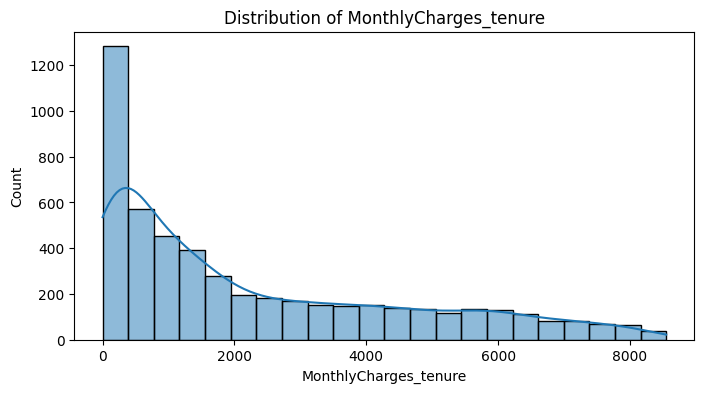

/Users/abhishek/projects/upskill/telco-customer-churn-analysis/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/abhishek/projects/upskill/telco-customer-churn-analysis/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/abhishek/projects/upskill/telco-customer-churn-analysis/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


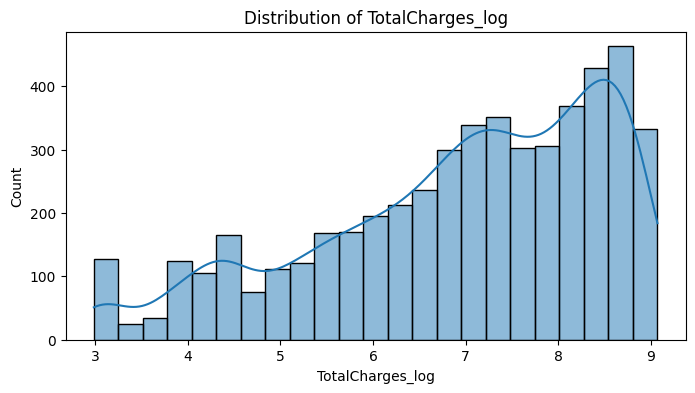

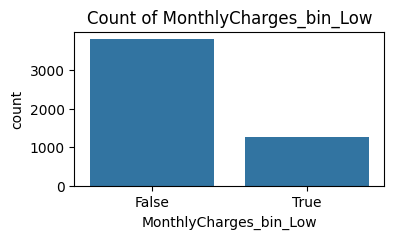

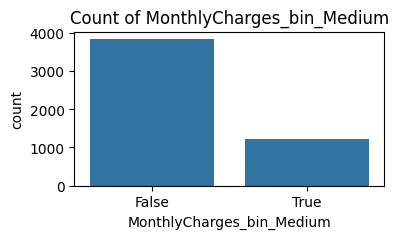

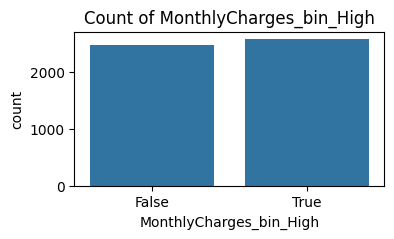

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize new features
def plot_new_features(df):
    features = ['MonthlyCharges_tenure', 'TotalCharges_log']
    for feat in features:
        if feat in df.columns:
            plt.figure(figsize=(8, 4))
            sns.histplot(df[feat].dropna(), kde=True)
            plt.title(f'Distribution of {feat}')
            plt.show()
    # Visualize binned MonthlyCharges
    for label in ['MonthlyCharges_bin_Low', 'MonthlyCharges_bin_Medium', 'MonthlyCharges_bin_High']:
        if label in df.columns:
            plt.figure(figsize=(4, 2))
            sns.countplot(x=df[label])
            plt.title(f'Count of {label}')
            plt.show()

plot_new_features(train_df)